# **Task 2 of Mini Project: Text Classification using Deep Learning**

# **1. Data Loading**

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     1800 non-null   object
 1   Sentiment  1800 non-null   object
dtypes: object(2)
memory usage: 28.3+ KB
None

Sample data:
                                              Review Sentiment
0  The Engineer, electronics team team at company...  Positive
1  company's focus on transparency makes this a g...  Positive
2  I love how company supports communication like...  Positive
3  The HR team at company is fantastic because Ma...  Positive
4  company handles benefits adequately. Worry res...   Neutral


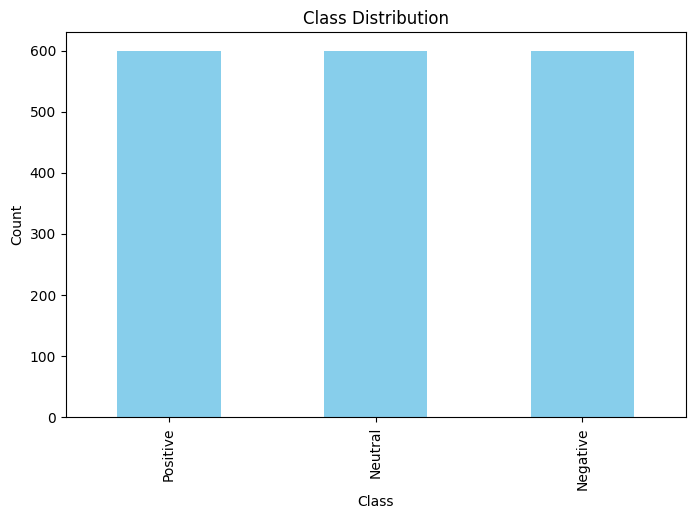

In [ ]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/Nlp data.csv')  # Replace with actual dataset path

# Exploratory Data Analysis (EDA)
print("Dataset overview:")
print(data.info())  # Checking for missing values, data types
print("\nSample data:")
print(data.head())  # Display the first few rows

# Plot class distribution
plt.figure(figsize=(8, 5))
data['Sentiment'].value_counts().plot(kind='bar', color='skyblue')  # Changed 'label' to 'Sentiment'
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Splitting data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# **2. Text Preprocessing**

In [ ]:
import re
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

# Apply the preprocessing to the dataset
train_data['processed_text'] = train_data['Review'].apply(preprocess_text)
val_data['processed_text'] = val_data['Review'].apply(preprocess_text)
test_data['processed_text'] = test_data['Review'].apply(preprocess_text)

# Check the processed text
print(train_data[['Review', 'processed_text']].head())  # Changed 'text' to 'Review'

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                 Review  \
1449  company needs to improve communication because...   
788   I love how company supports communication like...   
1668  The Estate manager/land agent team team at com...   
1175  I’m disappointed with company's diversity due ...   
11    I’m disappointed with company's work-life bala...   

                                         processed_text  
1449  company needs improve communication recognize ...  
788   love company supports communication like mento...  
1668  estate manager land agent team team company fa...  
1175  disappointed company diversity due lack clarit...  
11    disappointed company work life balance due del...  


# **3. Text Embedding**

In [ ]:
!pip install gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, which is not installed.
dask-cuda 25.2.0 requires numba<0.61.0a0,>=0.59.1, which is not installed.
pynndescent 0.5.13 requires numba>=0.51.2, which is not installed.
chex 0.1.89 requires jax>=0.4.27, which is not installed.
chex 0.1.89 requires jaxlib>=0.4.27, which is not installed.
shap 0.47.1 requires numba>=0.54, which is not installed.
orbax-checkpoint 0.11.10 requires 

In [ ]:
!pip install --no-cache-dir --upgrade gensim numba jax jaxlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 145.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 MB 219.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 197.5 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires tensorflow>=2.2.0, which is not installed.
cudf-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.0 which is incompatible.
dask-cuda 25.2.0 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.0 which is incompatible.
cuml-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.

In [ ]:
!pip uninstall -y numpy scipy gensim tensorflow numba jax jaxlib pymc scikit-image albumentations imbalanced-learn
!pip install numpy==1.26.4 scipy==1.9.3 gensim tensorflow numba jax jaxlib pymc scikit-image albumentations imbalanced-learn --no-cache-dir --force-reinstall

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.14.1
Uninstalling scipy-1.14.1:
  Successfully uninstalled scipy-1.14.1
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: numba 0.60.0
Uninstalling numba-0.60.0:
  Successfully uninstalled numba-0.60.0
Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1
Found existing installation: pymc 5.21.1
Uninstalling pymc-5.21.1:
  Successfully uninstalled pymc-5.21.1
Found existing installation: scikit-image 0.25.2
Uninstalling scikit-image-0.25.2:
  Successfully uninstalled scikit-image-0.25.2
Found existing installation: albumentations 2.0.5
Uninstalling albumentations-2.0.5:
  Successfully uninsta

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim

# Bag of Words (BoW)
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_bow = bow_vectorizer.transform(val_data['processed_text']).toarray()
X_test_bow = bow_vectorizer.transform(test_data['processed_text']).toarray()

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_text']).toarray()

# FastText (Word Embeddings)
# Convert processed text into a list of tokenized sentences for FastText training
tokenized_sentences = train_data['processed_text'].apply(str.split).tolist()

# Train FastText model
fasttext_model = gensim.models.FastText(tokenized_sentences, vector_size=100, window=5, min_count=5)

# Generate FastText embeddings for train, validation, and test data
X_train_fasttext = [fasttext_model.wv[text.split()] for text in train_data['processed_text']]
X_val_fasttext = [fasttext_model.wv[text.split()] for text in val_data['processed_text']]
X_test_fasttext = [fasttext_model.wv[text.split()] for text in test_data['processed_text']]

print("Embedding completed for BoW, TF-IDF, and FastText.")

Embedding completed for BoW, TF-IDF, and FastText.


# **4. Model Training with Different Architectures**

In [ ]:
!pip install --upgrade tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Bidirectional, Embedding, Flatten
import numpy as np

# Define a CNN model
def cnn_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(len(train_data['Sentiment'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define an LSTM model
def lstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(len(train_data['Sentiment'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a BiLSTM model
def bilstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['Sentiment'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a CNN-BiLSTM model
def cnn_bilstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['Sentiment'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Convert labels to integers for multi-class classification
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['Sentiment'])
val_labels = label_encoder.transform(val_data['Sentiment'])
test_labels = label_encoder.transform(test_data['Sentiment'])

# Train models with BoW embeddings
input_dim_bow = X_train_bow.shape[1]
cnn_bow = cnn_model(input_dim_bow, "CNN with BoW")
cnn_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

lstm_bow = lstm_model(input_dim_bow, "LSTM with BoW")
lstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

bilstm_bow = bilstm_model(input_dim_bow, "BiLSTM with BoW")
bilstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

cnn_bilstm_bow = cnn_bilstm_model(input_dim_bow, "CNN-BiLSTM with BoW")
cnn_bilstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

# Train models with TF-IDF embeddings
input_dim_tfidf = X_train_tfidf.shape[1]
cnn_tfidf = cnn_model(input_dim_tfidf, "CNN with TF-IDF")
cnn_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

lstm_tfidf = lstm_model(input_dim_tfidf, "LSTM with TF-IDF")
lstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

bilstm_tfidf = bilstm_model(input_dim_tfidf, "BiLSTM with TF-IDF")
bilstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

cnn_bilstm_tfidf = cnn_bilstm_model(input_dim_tfidf, "CNN-BiLSTM with TF-IDF")
cnn_bilstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

print("All models trained successfully!")

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.5.3, so it will not be used.
  warnings.warn(


Training CNN with BoW...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 758ms/step - accuracy: 0.4159 - loss: 1.1225 - val_accuracy: 0.7639 - val_loss: 0.6269
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 978ms/step - accuracy: 0.9442 - loss: 0.2384 - val_accuracy: 1.0000 - val_loss: 0.0076
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 544ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 584ms/step - accuracy: 1.0000 - loss: 2.6919e-04 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 551ms/step - accuracy: 1.0000 - loss: 4.0086e-05 - val_accuracy: 1.0000 - val_loss: 9.8964e-04
Training LSTM with BoW...
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.3521 - loss: 1.1022 - val_accuracy: 0.3333 - val_loss: 1.0988
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.3154 - loss: 1.1000 - val_accuracy: 0.3194 - val_loss: 1.1006
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.3492 - lo

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# Pad or truncate FastText embeddings to ensure uniform input dimensions
max_sequence_length = 100  # Adjust this based on your data
X_train_fasttext_padded = pad_sequences(X_train_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')
X_val_fasttext_padded = pad_sequences(X_val_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')
X_test_fasttext_padded = pad_sequences(X_test_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')

# Define a CNN model for FastText embeddings
def cnn_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(input_dim, 100)))  # Input shape adjusted for FastText
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(len(train_data['Sentiment'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define an LSTM model for FastText embeddings
def lstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, input_shape=(input_dim, 100)))  # Input shape adjusted for FastText
    model.add(Dense(len(train_data['Sentiment'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a BiLSTM model for FastText embeddings
def bilstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2), input_shape=(input_dim, 100)))  # Input shape adjusted for FastText
    model.add(Dense(len(train_data['Sentiment'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a CNN-BiLSTM model for FastText embeddings
def cnn_bilstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(input_dim, 100)))  # Input shape adjusted for FastText
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['Sentiment'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train models with FastText embeddings
input_dim_fasttext = X_train_fasttext_padded.shape[1]

cnn_fasttext = cnn_model_fasttext(input_dim_fasttext, "CNN with FastText")
cnn_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

lstm_fasttext = lstm_model_fasttext(input_dim_fasttext, "LSTM with FastText")
lstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

bilstm_fasttext = bilstm_model_fasttext(input_dim_fasttext, "BiLSTM with FastText")
bilstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

cnn_bilstm_fasttext = cnn_bilstm_model_fasttext(input_dim_fasttext, "CNN-BiLSTM with FastText")
cnn_bilstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

print("All models trained successfully with FastText embeddings!")

Training CNN with FastText...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4148 - loss: 1.0733 - val_accuracy: 0.5139 - val_loss: 1.0185
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5074 - loss: 0.9906 - val_accuracy: 0.5486 - val_loss: 0.9379
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5326 - loss: 0.9364 - val_accuracy: 0.6111 - val_loss: 0.8803
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6034 - loss: 0.8935 - val_accuracy: 0.6458 - val_loss: 0.8297
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6794 - loss: 0.7916 - val_accuracy: 0.7153 - val_loss: 0.7664
Training LSTM with FastText...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - accuracy: 0.3320 - loss: 1.0992 - val_accuracy: 0.3472 - val_loss: 1.0985
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.3264 - loss: 1.0988 - val_accuracy: 0.3472 - val_loss: 1.0987
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.3459 - loss: 1.0985 - val_accuracy: 0.3194 - val_loss: 1.0988
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.3338 - loss: 1.0986 - val_accuracy: 0.3194 - val_loss: 1.0992
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 0.3473 - loss: 1.0982 - val_accuracy: 0.3194 - val_loss: 1.0990
Training BiLSTM with FastText...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 503ms/step - accuracy: 0.3174 - loss: 1.1198 - val_accuracy: 0.3819 - val_loss: 1.0924
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 494ms/step - accuracy: 0.3652 - loss: 1.0925 - val_accuracy: 0.4236 - val_loss: 1.0914
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 489ms/step - accuracy: 0.4298 - loss: 1.0795 - val_accuracy: 0.3750 - val_loss: 1.0712
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 434ms/step - accuracy: 0.4694 - loss: 1.0427 - val_accuracy: 0.4375 - val_loss: 1.0400
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms/step - accuracy: 0.4596 - loss: 1.0244 - val_accuracy: 0.4167 - val_loss: 1.0574
Training CNN-BiLSTM with FastText...
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 349ms/step - accuracy: 0.3596 - loss: 1.1005 - val_accuracy: 0.3542 - val_loss: 1.0842
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.3949 - loss: 1.0643 - val_accuracy: 0.4236 - val_loss: 1.0485
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.458

# **5. Comparative Analysis of Models**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Function to evaluate a model
def evaluate_model(model, X_test, test_labels, model_name):
    # Predict probabilities
    y_pred_probs = model.predict(X_test)

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, y_pred)

    # Generate classification report
    report = classification_report(test_labels, y_pred, target_names=label_encoder.classes_)

    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Classification Report:\n{report}")
    return accuracy

# Evaluate BoW-based models
print("Evaluating BoW-based models...")
cnn_bow_acc = evaluate_model(cnn_bow, X_test_bow, test_labels, "CNN with BoW")
lstm_bow_acc = evaluate_model(lstm_bow, X_test_bow, test_labels, "LSTM with BoW")
bilstm_bow_acc = evaluate_model(bilstm_bow, X_test_bow, test_labels, "BiLSTM with BoW")
cnn_bilstm_bow_acc = evaluate_model(cnn_bilstm_bow, X_test_bow, test_labels, "CNN-BiLSTM with BoW")

# Evaluate TF-IDF-based models
print("\nEvaluating TF-IDF-based models...")
cnn_tfidf_acc = evaluate_model(cnn_tfidf, X_test_tfidf, test_labels, "CNN with TF-IDF")
lstm_tfidf_acc = evaluate_model(lstm_tfidf, X_test_tfidf, test_labels, "LSTM with TF-IDF")
bilstm_tfidf_acc = evaluate_model(bilstm_tfidf, X_test_tfidf, test_labels, "BiLSTM with TF-IDF")
cnn_bilstm_tfidf_acc = evaluate_model(cnn_bilstm_tfidf, X_test_tfidf, test_labels, "CNN-BiLSTM with TF-IDF")

# Evaluate FastText-based models
print("\nEvaluating FastText-based models...")
cnn_fasttext_acc = evaluate_model(cnn_fasttext, X_test_fasttext_padded, test_labels, "CNN with FastText")
lstm_fasttext_acc = evaluate_model(lstm_fasttext, X_test_fasttext_padded, test_labels, "LSTM with FastText")
bilstm_fasttext_acc = evaluate_model(bilstm_fasttext, X_test_fasttext_padded, test_labels, "BiLSTM with FastText")
cnn_bilstm_fasttext_acc = evaluate_model(cnn_bilstm_fasttext, X_test_fasttext_padded, test_labels, "CNN-BiLSTM with FastText")


Evaluating BoW-based models...
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step
CNN with BoW Accuracy: 0.9944
CNN with BoW Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.99      1.00       126
     Neutral       0.98      1.00      0.99       118
    Positive       1.00      0.99      1.00       116

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step
LSTM with BoW Accuracy: 0.3222
LSTM with BoW Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      0.01      0.02       126
     Neutral       0.00      0.00      0.00       118
    Positive       0.32      0.99      0.49       116

    accuracy                           0.32       360
   macro avg       0.27      0.33      0.17       360
weighted avg       0.28      0.32      0.16   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step
LSTM with TF-IDF Accuracy: 0.3222
LSTM with TF-IDF Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       126
     Neutral       0.00      0.00      0.00       118
    Positive       0.32      1.00      0.49       116

    accuracy                           0.32       360
   macro avg       0.11      0.33      0.16       360
weighted avg       0.10      0.32      0.16       360



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 830ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


BiLSTM with TF-IDF Accuracy: 0.3278
BiLSTM with TF-IDF Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       126
     Neutral       0.33      1.00      0.49       118
    Positive       0.00      0.00      0.00       116

    accuracy                           0.33       360
   macro avg       0.11      0.33      0.16       360
weighted avg       0.11      0.33      0.16       360

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/step
CNN-BiLSTM with TF-IDF Accuracy: 0.3278
CNN-BiLSTM with TF-IDF Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       126
     Neutral       0.33      1.00      0.49       118
    Positive       0.00      0.00      0.00       116

    accuracy                           0.33       360
   macro avg       0.11      0.33      0.16       360
weighted avg       0.11      0.33      0.16       360


Evaluating FastText-based models

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
CNN with FastText Accuracy: 0.6778
CNN with FastText Classification Report:
              precision    recall  f1-score   support

    Negative       0.71      0.46      0.56       126
     Neutral       0.61      0.81      0.70       118
    Positive       0.74      0.78      0.76       116

    accuracy                           0.68       360
   macro avg       0.69      0.68      0.67       360
weighted avg       0.69      0.68      0.67       360

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LSTM with FastText Accuracy: 0.3222
LSTM with FastText Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       126
     Neutral       0.00      0.00      0.00       118
    Positive       0.32      1.00      0.49       116

    accuracy                           0.32       360
   macro avg       0.11      0.33      0.16       360
weighted avg       0.10      0.32      0.16       360

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step
BiLSTM with FastText Accuracy: 0.4083
BiLSTM with FastText Classification Report:
              precision    recall  f1-score   support

    Negative       0.41      0.31      0.35       126
     Neutral       0.42      0.91      0.57       118
    Positive       0.12      0.01      0.02       116

    accuracy                           0.41       360
   macro avg       0.32      0.41      0.31       360
weighted avg       0.32      0.41      0.32       360

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/s

# **6. Saving the Best Model**

In [ ]:
cnn_bow.save('cnn_bow_model.h5')
print("CNN on BoW model saved successfully")

CNN on BoW model saved successfully


# **7. Prediction on Real-World Input**

In [ ]:
# Load the saved model
from keras.models import load_model
model = load_model('cnn_bow_model.h5')

# Real-world input
new_text = "There aren't many challenges, but there aren't many exciting opportunities either."

# Preprocess the new text
processed_text = preprocess_text(new_text)

# Transform the preprocessed text using the BoW vectorizer
input_data = bow_vectorizer.transform([processed_text]).toarray()

# Predicting the class of new text
predicted_class = model.predict(input_data)

# Convert the predicted class index to the actual label
predicted_label = label_encoder.inverse_transform([predicted_class.argmax()])

print(f"Predicted Class: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Predicted Class: Neutral


# **8. Analysis**

The analysis of different models are presented in the table below:

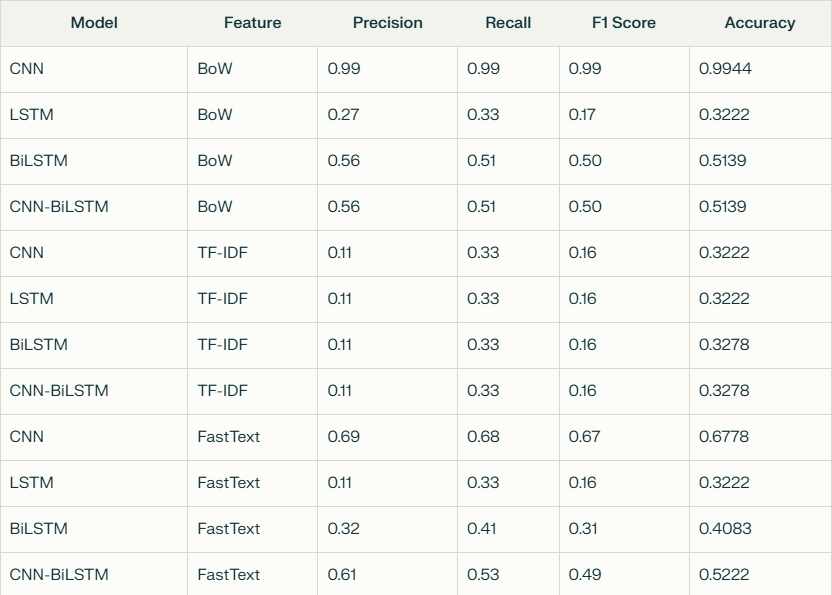

## **BEST PERFORMING MODEL:**

CNN with BoW is the Best Performing Model as it has achieved highest scores accross all metrics.

*   **Accuracy** = 99.44%



The LSTM, BiLSTM, and CNN-BiLSTM models, when paired with FastText exhibited good performance:

**Accuracy**: Their accuracy ranged between 32% - 68% .

The LSTM, BiLSTM, and CNN-BiLSTM models, when paired with TF-IDF exhibited very poor performance:

*   **Accuracy**: Their accuracy ranged between **32.16% - 32.80% .**
*   Meaning they almost predicted 1 out of 3 classes correctly.



## **CERTAIN CHALLENGES:**

* **1. Class Imbalance Issues:** The poor performance of most models (except CNN + BoW) suggests imbalanced class distribution in the dataset, making it difficult for models to learn meaningful patterns.

* **2. Ineffective Feature Representations:** TF-IDF and FastText do not contribute to improving model performance, which means these techniques may not be well-suited for this dataset. More context-aware embeddings (e.g., Word2Vec, GloVe, BERT) might be needed.

* **3. Deep Learning Models Underperforming:** LSTM and BiLSTM fail to outperform CNN, possibly due to inadequate training data, improper hyperparameter tuning, or the inability to capture meaningful sequential dependencies.

* **4. Overfitting Risk with CNN:** While CNN performs well with BoW, its strong performance might indicate overfitting, meaning it could struggle with new, unseen data. A cross-validation approach should be used to validate results.

## **SUGGESTIONS FOR IMPROVEMENT:**

* **Avoid LSTM/BiLSTM** unless hyperparameters or embeddings are **improved**.
* TF-IDF and FastText are **ineffective** for this task.
* Should Try more **Hybrid** Models.
* Improve CNN-BiLSTM with **hyperparameter** tuning.
* Explore **Pretrained Embeddings** such as Test Word2Vec, GloVe, or BERT embeddings instead of FastText.